The network predicts quality scores transformed from GMM loglikelihood for the between-subject case. The input to the network are the augmented data with 117 dimensions.

The split function is used to split data randomly.

RNN_GMM_Between_M1_Aug: predict quality scores for the augmented data and “DataA_Load” is called to load data.


In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

from sklearn.model_selection import train_test_split


C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# length of data sequences
timesteps = 240
# repetition number
nr = 90
# Dimension of data sequences
n_dim = 117
# Droput rate
dropout_rate = 0.2

In [3]:
# Import the data
import DataA_Load
A_data = list(range(6))
for a in range(6):
    A_data[a]= DataA_Load.load_data(a+1) 
    print(A_data[a][0].shape) # Print the size of the data
    print(A_data[a][1].shape) # print the size of corresponding label

(90, 240, 117)
(90, 1)
(90, 240, 117)
(90, 1)
(90, 240, 117)
(90, 1)
(90, 240, 117)
(90, 1)
(90, 240, 117)
(90, 1)
(90, 240, 117)
(90, 1)


In [4]:
# merge data
DataA_X = np.concatenate((A_data[0][0],A_data[1][0],A_data[2][0],A_data[3][0],A_data[4][0],A_data[5][0]))
print(DataA_X.shape)
# merge label
DataA_Y = np.concatenate((A_data[0][1],A_data[1][1],A_data[2][1],A_data[3][1],A_data[4][1],A_data[5][1]))
print(DataA_Y.shape)

(540, 240, 117)
(540, 1)


In [5]:
# split data
train_x, valid_x, train_y, valid_y = train_test_split(DataA_X, DataA_Y, test_size=0.3, random_state=0)
print('training data shape', train_x.shape)
print('shape of training labels', train_y.shape)
print('validation data shape', valid_x.shape)
print('shape of validation label', valid_y.shape)

training data shape (378, 240, 117)
shape of training labels (378, 1)
validation data shape (162, 240, 117)
shape of validation label (162, 1)


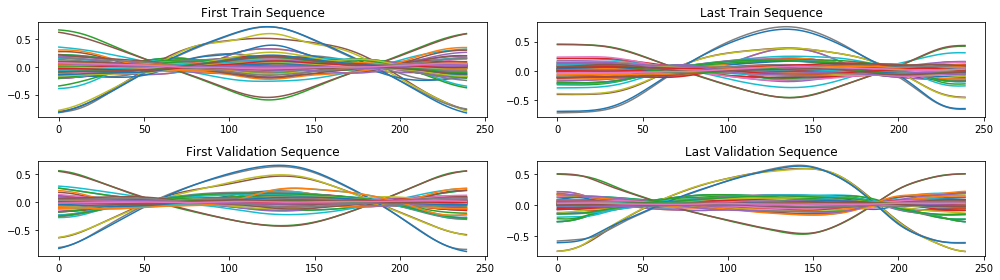

In [6]:
# Plot the first and last sequence in the training and validation data
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

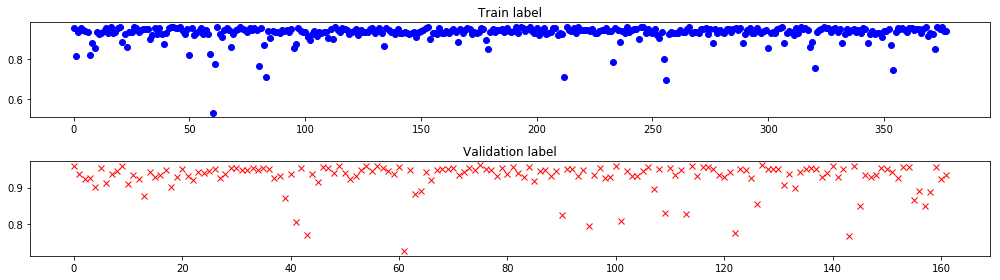

In [7]:
# Plot the first and last sequence in the training and validation label
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,1,1)
plt.plot(train_y,'bo')
plt.title('Train label')
#########################
plt.subplot(2,1,2)
plt.plot(valid_y,'rx')
plt.title('Validation label')

plt.tight_layout()
plt.show()

In [8]:
# Build RNN model ...
def Network():
    model = Sequential()

    model.add(Bidirectional(LSTM(20, recurrent_dropout = 0.5, return_sequences = True), input_shape = (timesteps,n_dim)))
    model.add(Dropout(0.25))

    model.add(Dense(30, activation = 'tanh'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(10, recurrent_dropout = 0.5)))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    #model.summary()
    
    # Measure the training time and implement early stoping
    # In my case it took less than 4 minutes to train the model
    t = now()
    from keras.callbacks import EarlyStopping

    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    history = model.fit(train_x, train_y, batch_size=10, epochs=5000, verbose=0, 
                         validation_data=(valid_x, valid_y),
                         callbacks = [early_stopping])

    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()

    # Print the minimum loss
    print("Training loss", np.min(history.history['loss']))
    print("Validation loss",np.min(history.history['val_loss']))
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(train_x)
    pred_test = model.predict(valid_x)

    plt.figure(figsize = (14,4))
    plt.subplot(1,2,1)
    plt.plot(pred_train,'bo',train_y,'g*')
    plt.ylim([-0.1,1.1])
    plt.title('Labels for the training set')
    plt.subplot(1,2,2)
    plt.plot(pred_test,'bo',valid_y,'g*')
    plt.title('Labels for the testing set')
    plt.ylim([-0.1,1.1])
    plt.tight_layout()
    plt.show()
    
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    # train_dev = abs(np.squeeze(pred_train)-train_y)
    test_dev = abs(np.squeeze(pred_test)-np.squeeze(valid_y))
    mean_abs_dev = np.mean(test_dev)
    print('mean absolute deviation', mean_abs_dev)

    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
    print('rms deviation', rms_dev)
    
    return mean_abs_dev, rms_dev
    


Training time: 0:26:53.013535


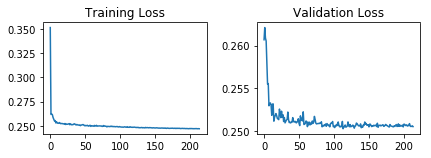

Training loss 0.24718484156346196
Validation loss 0.2502900380411266


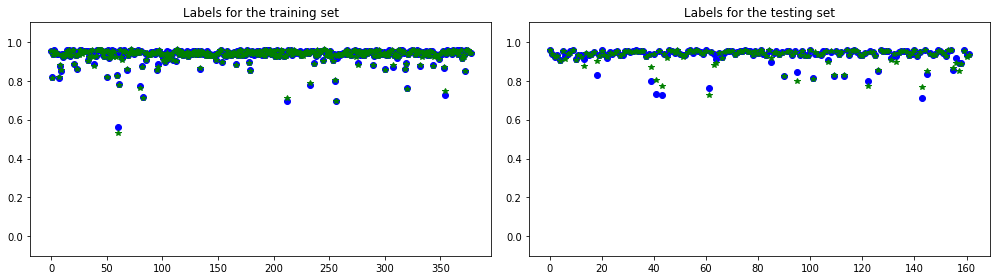

mean absolute deviation 0.007089891882884645
rms deviation 0.015173614516802252


In [9]:
# deviation for ten times
Mean_abs_dev, RMS_dev  = Network() 